<a href="https://colab.research.google.com/github/ryanzone/ICM_ML/blob/main/ICM_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
!pip install -q kaggle
!pip install -q gradio
%config Completer.use_jedi = False
%matplotlib inline
%pip install scikit-learn




In [103]:
from google.colab import files
files.upload()

{}

In [104]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [105]:
! cp kaggle.json ~/.kaggle/

In [106]:
! chmod 600 ~/.kaggle/kaggle.json

In [107]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --unzip



Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:23<00:00, 263MB/s]
100% 2.29G/2.29G [00:23<00:00, 103MB/s]


In [108]:
!rm -rf /content/TB_Chest_Radiography_Database


In [109]:
import os, time, copy, glob, random
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18


In [110]:
train_normal = glob.glob("chest_xray/train/NORMAL/*")
train_pneumonia = glob.glob("chest_xray/train/PNEUMONIA/*")


test_normal = glob.glob("chest_xray/test/NORMAL/*")
test_pneumonia = glob.glob("chest_xray/test/PNEUMONIA/*")



In [111]:
train_paths = train_normal + train_pneumonia
test_paths = test_normal + test_pneumonia

train_labels = [0]*len(train_normal) + [1]*len(train_pneumonia)
test_labels = [0]*len(test_normal) + [1]*len(test_pneumonia)


In [112]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)


In [113]:
class XRayDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.transform:
            img = self.transform(img)
        return img, label


In [129]:
class PneumoniaModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        return self.model(x)


In [115]:
image_size = (224, 224)

train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [116]:
train_ds = XRayDataset(train_paths, train_labels, train_transform)
val_ds = XRayDataset(valid_paths, valid_labels, test_transform)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

dataloaders = {"train": train_dl, "val": val_dl}
sizes = {"train": len(train_ds), "val": len(val_ds)}


In [117]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
!nvidia-smi


Device: cuda
Sun Dec 14 06:27:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P0             34W /   70W |    1268MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------------

In [131]:
from collections import Counter

# model (2 classes now)
model = PneumoniaModel(2).to(device)

# 🔴 FREEZE BACKBONE (FIXED ATTRIBUTE)
for param in model.model.parameters():
    param.requires_grad = False

for param in model.model.fc.parameters():
    param.requires_grad = True

# 🔴 CLASS-WEIGHTED LOSS
class_counts = Counter(train_labels)
total = sum(class_counts.values())

weights = torch.tensor(
    [total / class_counts[0], total / class_counts[1]],
    dtype=torch.float
).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)

# 🔴 LOWER LR
optimizer = Adam(model.parameters(), lr=3e-4)


In [132]:
# ===== METRIC STORAGE (DO NOT SKIP) =====
train_acc_history = []
val_acc_history = []

train_loss_history = []
val_loss_history = []

y_true = []
y_pred = []


In [133]:
def train_model(model, epochs=5):
    best_acc = 0
    best_wts = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        for phase in ["train","val"]:
            model.train() if phase=="train" else model.eval()
            loss_sum, correct = 0, 0

            for x,y in dataloaders[phase]:
                x,y = x.to(device), y.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=="train"):
                    out = model(x)
                    loss = criterion(out,y)
                    pred = out.argmax(1)

                    if phase=="train":
                        loss.backward()
                        optimizer.step()

                loss_sum += loss.item()*x.size(0)
                correct += (pred==y).sum().item()


            acc = correct / sizes[phase]
            print(f"{phase} acc: {acc:.4f}")

            # ===== STORE METRICS =====
            if phase == "train":
                train_acc_history.append(acc)
            else:
                val_acc_history.append(acc)


            if phase=="val" and acc>best_acc:
                best_acc = acc
                best_wts = copy.deepcopy(model.state_dict())
                torch.save(best_wts,"best_model.pth")

    model.load_state_dict(best_wts)
    return model


In [134]:
model = train_model(model, epochs=5)



Epoch 1/5
train acc: 0.8181
val acc: 0.7625

Epoch 2/5
train acc: 0.9094
val acc: 0.8870

Epoch 3/5
train acc: 0.9130
val acc: 0.8755

Epoch 4/5
train acc: 0.9209
val acc: 0.9042

Epoch 5/5
train acc: 0.9228
val acc: 0.9138


In [138]:
model.cpu().eval()

def predict(path):
    img = Image.open(path).convert("RGB")
    x = test_transform(img).unsqueeze(0)
    with torch.no_grad():
        out = model(x)
        prob = torch.softmax(out,1)[0]
        idx = prob.argmax().item()
    return ["Normal","Pneumonia"][idx], prob[idx].item()

print(predict(random.choice(test_paths)))


('Pneumonia', 0.6052104234695435)


In [140]:
# ===== COLLECT y_true AND y_pred FOR METRICS & GRAPHS =====
y_true = []
y_pred = []

model.eval()

with torch.no_grad():
    for inputs, labels in val_dl:   # <-- FIXED NAME
        inputs = inputs.cpu()       # model is on CPU
        labels = labels.cpu()

        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.numpy())

print("Collected y_true and y_pred")


Collected y_true and y_pred


In [141]:
import gradio as gr
import traceback

def gradio_predict(img):
    try:
        img = img.convert("RGB")
        x = test_transform(img).unsqueeze(0)
        with torch.no_grad():
            out = model(x)
            prob = torch.softmax(out,1)[0]
            idx = prob.argmax().item()
        return f"{['Normal','Pneumonia','Tuberculosis'][idx]} ({prob[idx]:.4f})"
    except Exception:
        return traceback.format_exc()

gr.Interface(
    fn=gradio_predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(),
    title="Chest X-ray Classifier"
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7f24bae75223dd11e2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


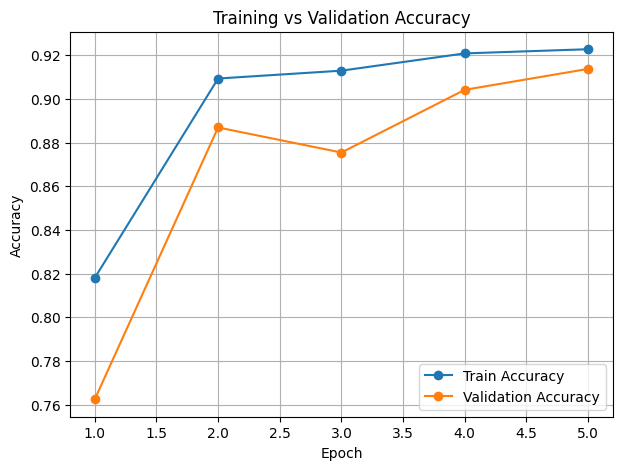

In [142]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc_history) + 1)

plt.figure(figsize=(7,5))
plt.plot(epochs, train_acc_history, marker='o', label="Train Accuracy")
plt.plot(epochs, val_acc_history, marker='o', label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


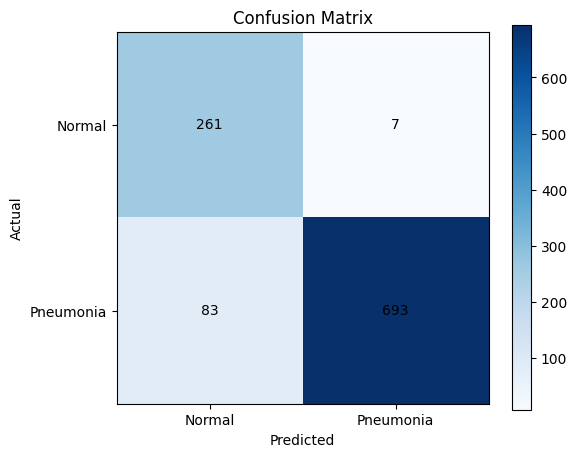

In [145]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# auto-detect labels present
unique_labels = np.unique(y_true)

class_map = {
    0: "Normal",
    1: "Pneumonia",
}

used_classes = [class_map[i] for i in unique_labels]

cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(len(used_classes)), used_classes)
plt.yticks(range(len(used_classes)), used_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# annotate dynamically (NO hardcoded 3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()


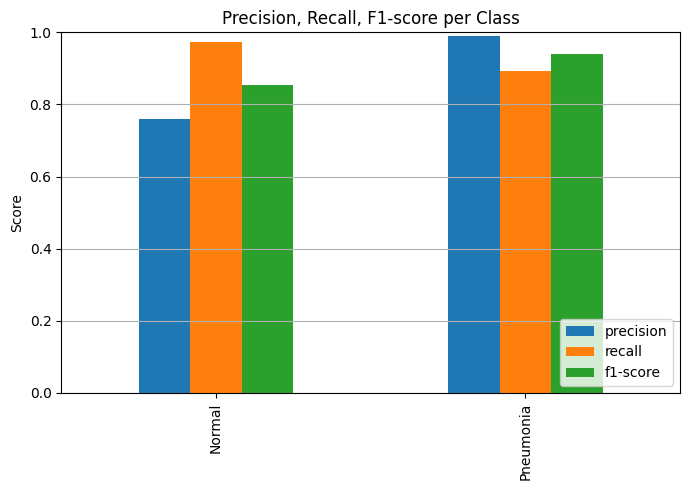

In [144]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

unique_labels = np.unique(y_true)

class_map = {
    0: "Normal",
    1: "Pneumonia"
}

used_class_names = [class_map[i] for i in unique_labels]

report = classification_report(
    y_true,
    y_pred,
    labels=unique_labels,
    target_names=used_class_names,
    output_dict=True,
    zero_division=0
)

df_all = pd.DataFrame(report).transpose()

# pick only rows that are actual classes AND exist
metric_rows = []
for cls in used_class_names:
    if cls in df_all.index:
        metric_rows.append(cls)

if len(metric_rows) == 0:
    print("⚠️ WARNING: Model predicted only ONE class.")
    print("⚠️ Precision/Recall per class cannot be plotted meaningfully.")
    print("\nRaw classification report:")
    print(df_all)
else:
    df = df_all.loc[metric_rows, ["precision", "recall", "f1-score"]]

    plt.figure(figsize=(7, 5))
    df.plot(kind="bar", ax=plt.gca())
    plt.title("Precision, Recall, F1-score per Class")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.grid(axis="y")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()